In [1]:
import pandas as pd 
from pathlib import Path

from utils import calculate_novelty, calculate_validity, calculate_uniqueness, compute_internal_diversity

In [2]:
data_dir = Path('..') / 'generated_mols' / 'scored'
zinc_scored_data = pd.read_csv(data_dir / 'scored_zinc.csv')
score_data = pd.read_csv(data_dir / 'generated_molecules_1000_True_charged_GNN_scored_logp_[4.0]_scored.csv')

data_smiles_list = score_data['smiles'].tolist()

In [14]:
filtered = zinc_scored_data[(zinc_scored_data['QED'] > 0.93)]


In [15]:
filtered['QED'].describe()

count    3179.000000
mean        0.937704
std         0.004826
min         0.930001
25%         0.933274
50%         0.937816
75%         0.941566
max         0.948442
Name: QED, dtype: float64

In [13]:
print(filtered['SA'].describe())

count    1083.000000
mean        3.576814
std         0.495384
min         3.000397
25%         3.168335
50%         3.426786
75%         3.896201
max         5.875019
Name: SA, dtype: float64


In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import SVG

def plot_molecules(df, num_mols=5):
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['smiles'].head(num_mols)]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True)

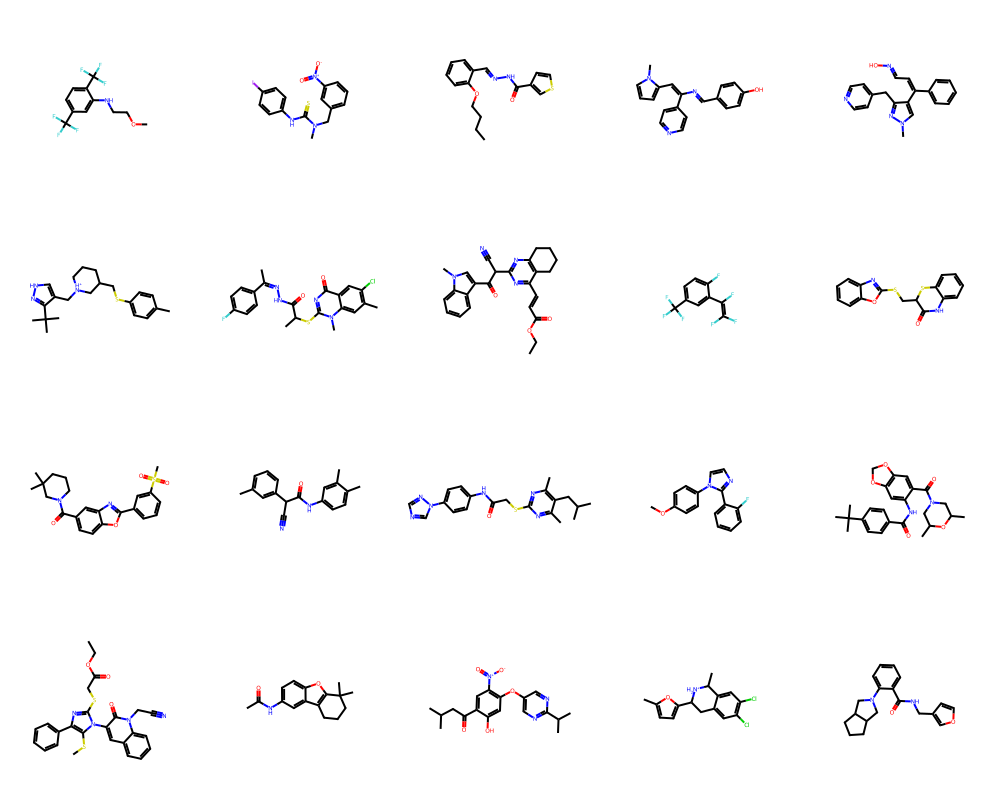

In [5]:
plot_molecules(score_data, num_mols=20)

In [29]:
validity, valid_molecules = calculate_validity(data_smiles_list)
uniqueness, unique_molecules = calculate_uniqueness(valid_molecules)
novelty, non_new_mols = calculate_novelty(unique_molecules, zinc_scored_data['smiles'].tolist())

[16:36:21] Explicit valence for atom # 24 N, 4, is greater than permitted


In [30]:
print("Validity: ", validity)
print("Unique: ", uniqueness)
print("Novelty: ", novelty)

Validity:  0.999
Unique:  1.0
Novelty:  0.995995995995996


In [31]:
# Return valid molecules dataset among the generated molecules

valid_mols_df = score_data[score_data['smiles'].isin(valid_molecules)]

In [32]:
compute_internal_diversity(valid_mols_df['smiles'].tolist())

0.866703599526721

In [60]:
zinc_scored_data

,smiles,SA,logP,QED,weight,n_rings
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,2.084095,5.05060,0.731901,325.383,3
1,CC1CC(C)CC(Nc2cncc(-c3nncn3C)c2)C1,3.432004,3.11370,0.941112,285.395,3
2,N#Cc1ccc(-c2ccc(OC(C(=O)N3CCCC3)c3ccccc3)cc2)cc1,2.470633,4.96778,0.626105,382.463,4
3,CCOC(=O)C1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c2CCCC...,2.822753,4.00022,0.716225,409.530,4
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])C(C#N)C1...,4.035182,3.60956,0.809572,413.910,3
...,...,...,...,...,...,...
249450,CC1(C)CCC(CNC(=O)Cn2ncc3ccccc3c2=O)c2ccccc21,2.900726,3.36790,0.760407,375.472,4
249451,Cn1ccnc1C(=O)c1ccc(NC(=O)C2CCN(C(=O)C(C)(C)C)C...,2.326627,2.87430,0.805660,396.491,3
249452,Cc1ccc(NC(=O)C(=O)N(C)Cc2ccccc2)c(C)c1,1.840642,2.90054,0.885407,296.370,2
249453,Cc1cc(C(=O)Nc2ccc(OCC(N)=O)cc2)c(C)n1C1CC1,2.024638,2.55624,0.854652,327.384,3


c:\Users\goupi\.conda\envs\torch_geometric\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


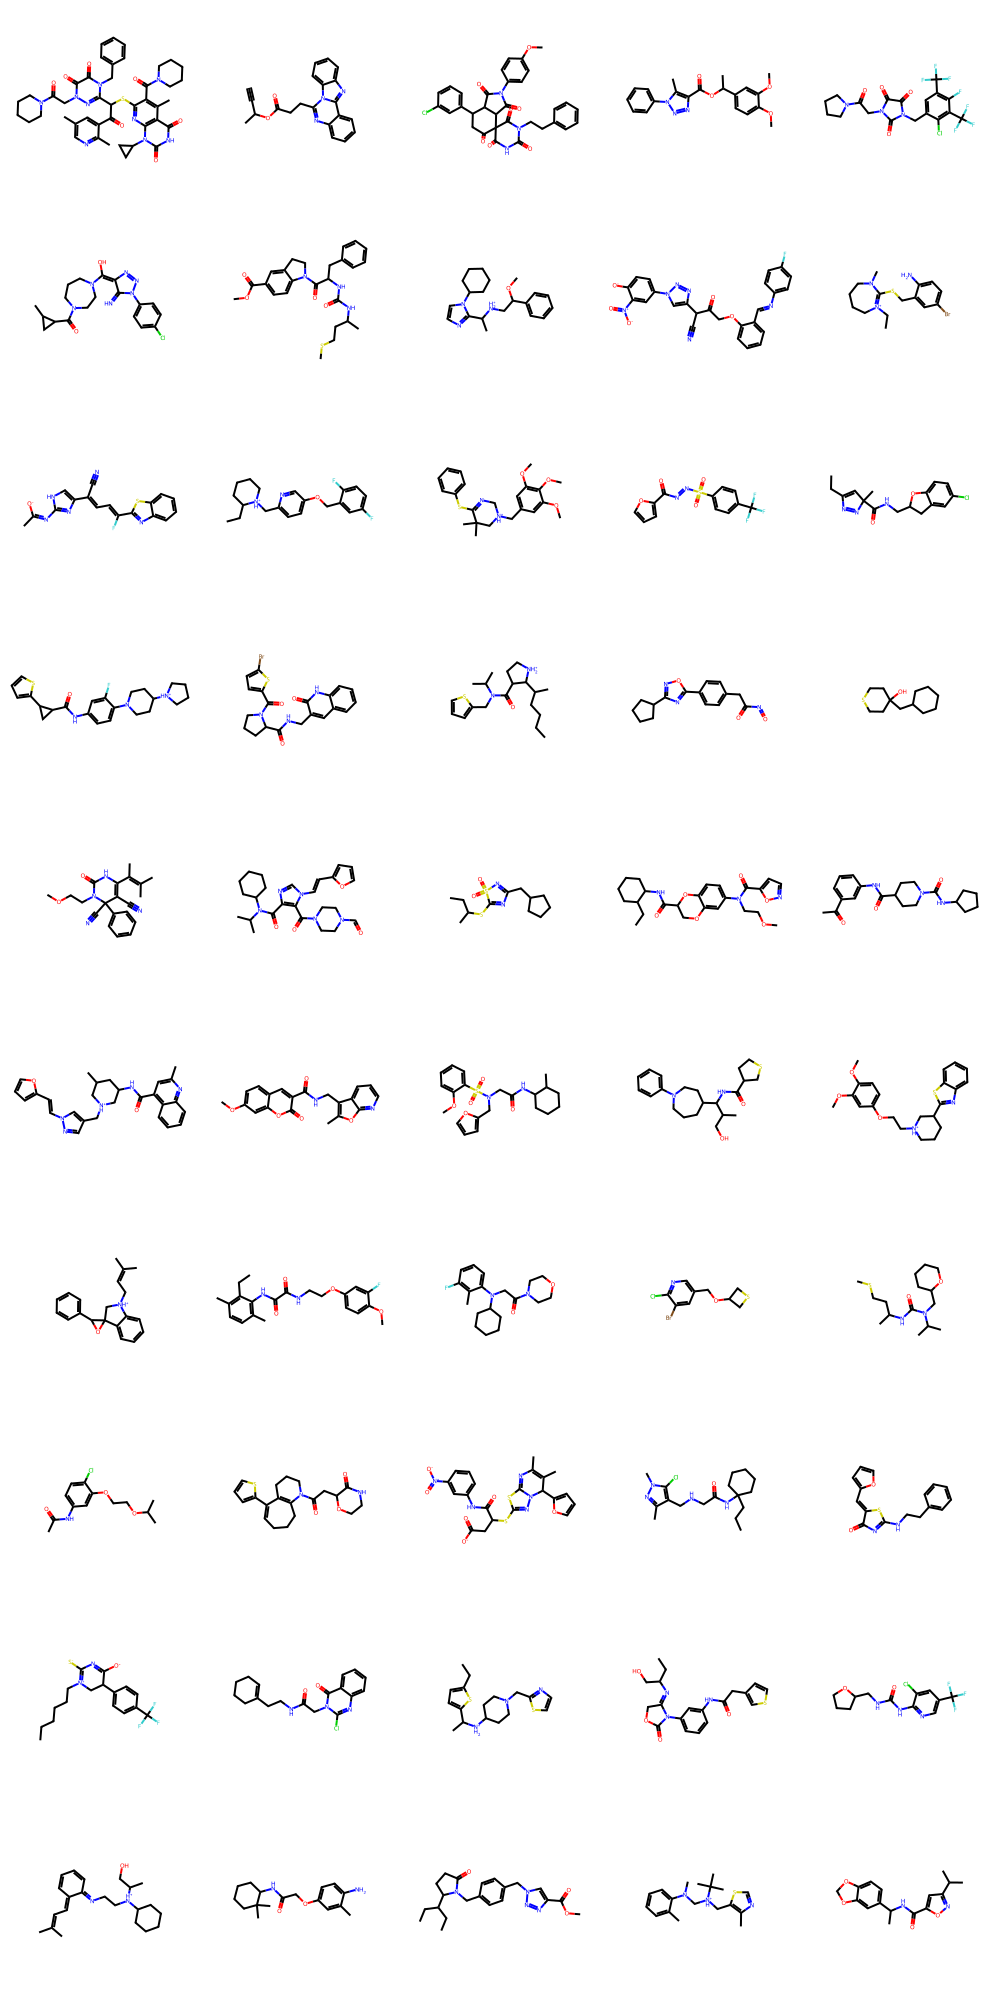

In [61]:
# Find the molecules with the highest logP score and them plot them    

plot_molecules(valid_mols_df.sort_values(by=['logP'], ascending=False), num_mols=100)

In [62]:
zinc_scored_data['logP'].describe()

count    249455.000000
mean          2.457121
std           1.434336
min          -6.876200
25%           1.574900
50%           2.605600
75%           3.486760
max           8.252100
Name: logP, dtype: float64

In [63]:
valid_mols_df['logP'].describe()

count    999.000000
mean       2.483596
std        0.327330
min        0.604800
25%        2.305630
50%        2.467800
75%        2.671400
max        3.861560
Name: logP, dtype: float64

C:\Users\goupi\AppData\Local\Temp\ipykernel_22064\2433341550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_mols_df.loc[:, 'logP'] = valid_mols_df['logP'].astype(float)


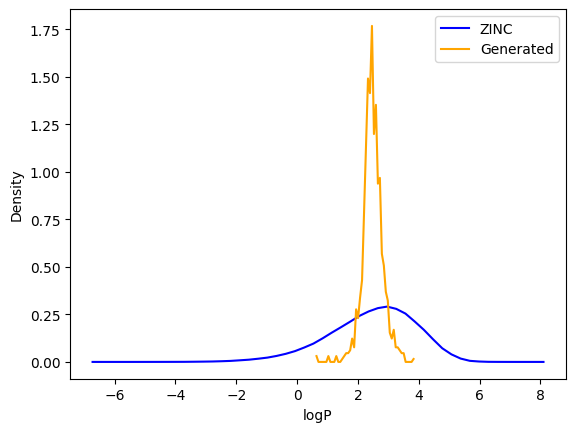

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the 'logP' column to float type
zinc_scored_data['logP'] = zinc_scored_data['logP'].astype(float)
valid_mols_df.loc[:, 'logP'] = valid_mols_df['logP'].astype(float)

# Compute normalized histograms
zinc_hist, zinc_bins = np.histogram(zinc_scored_data['logP'], bins=50, density=True)
gen_hist, gen_bins = np.histogram(valid_mols_df['logP'], bins=50, density=True)

# Compute bin centers
zinc_bin_centers = (zinc_bins[:-1] + zinc_bins[1:]) / 2
gen_bin_centers = (gen_bins[:-1] + gen_bins[1:]) / 2

# Plot histograms
plt.plot(zinc_bin_centers, zinc_hist, label='ZINC', color='blue')
plt.plot(gen_bin_centers, gen_hist, label='Generated', color='orange')

# Add a legend to the plot
plt.legend()

# Label axes
plt.xlabel('logP')
plt.ylabel('Density')

# Show the plot
plt.show()

C:\Users\goupi\AppData\Local\Temp\ipykernel_12144\3767564628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_mols_df.loc[:, 'SA'] = valid_mols_df['SA'].astype(float)


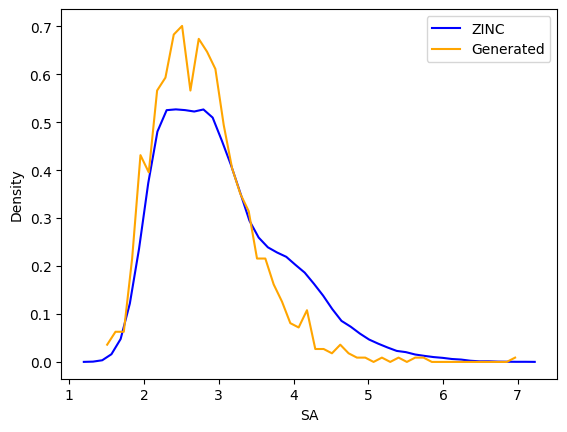

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the 'logP' column to float type
zinc_scored_data['SA'] = zinc_scored_data['SA'].astype(float)
valid_mols_df.loc[:, 'SA'] = valid_mols_df['SA'].astype(float)

# Compute normalized histograms
zinc_hist, zinc_bins = np.histogram(zinc_scored_data['SA'], bins=50, density=True)
gen_hist, gen_bins = np.histogram(valid_mols_df['SA'], bins=50, density=True)

# Compute bin centers
zinc_bin_centers = (zinc_bins[:-1] + zinc_bins[1:]) / 2
gen_bin_centers = (gen_bins[:-1] + gen_bins[1:]) / 2

# Plot histograms
plt.plot(zinc_bin_centers, zinc_hist, label='ZINC', color='blue')
plt.plot(gen_bin_centers, gen_hist, label='Generated', color='orange')

# Add a legend to the plot
plt.legend()

# Label axes
plt.xlabel('SA')
plt.ylabel('Density')

# Show the plot
plt.show()

In [ ]:
# Plot SA of generated molecules vs ZINC with normalized y axis

zinc_scored_data['SA'] = zinc_scored_data['SA'].astype(float)
score_data['SA'] = score_data['SA'].astype(float)

sns.distplot(zinc_scored_data['SA'], label='ZINC')
sns.distplot(score_data['SA'], label='Generated')
plt.legend()
plt.show()

C:\Users\goupi\AppData\Local\Temp\ipykernel_22064\3377980062.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_mols_df['num_atoms'] = valid_mols_df['smiles'].apply(get_molecule_size)


<Axes: ylabel='Frequency'>

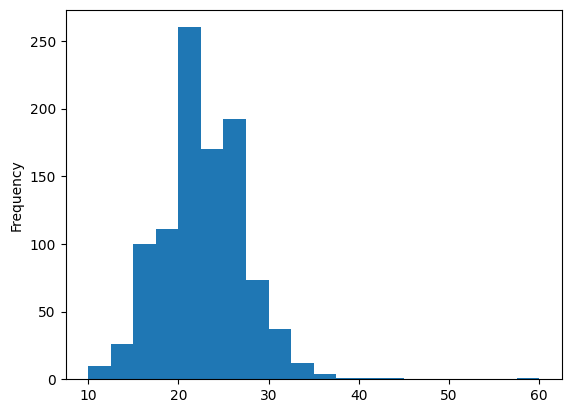

In [67]:
# Plot the distribution of the number of atoms in the generated molecules

from rdkit.Chem import Descriptors

def get_molecule_size(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms()

valid_mols_df['num_atoms'] = valid_mols_df['smiles'].apply(get_molecule_size)

valid_mols_df['num_atoms'].plot.hist(bins=20)

